In [1]:
import os
import numpy as np
from tensorflow import keras
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

plt.style.use('ggplot')

In [3]:
model_name = r"model_v3.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

model_path = os.path.join(model_path, model_name)

class MonteCarloDropout(keras.layers.Dropout):
    """Keeps dropout on in testing mode for uncertainty predictions"""
    def call(self, inputs):
        return super().call(inputs, training=True)

model = keras.models.load_model(model_path, custom_objects={"f1_score": f1_score, "MonteCarloDropout": MonteCarloDropout})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [4]:
def generate_sample():
    n = np.random.randint(0, event_X_test.shape[0])
    sample = [event_X_test.iloc[n:n+1].values, object_X_test[n:n+1]]
    y_true = y_test.iloc[n:n+1].values
    return (sample, y_true)


def predict_dist(X, model, n_models):
    preds = [model(X, training=False) for _ in tqdm(range(n_models))]
    return np.hstack(preds)
    

def plot_dist(sample, model, n_models):
    y_pred_dist = predict_dist(sample, model, n_models)
    y_pred = y_pred_dist.mean(axis=1)

    plt.figure(figsize=(10, 8))
    plt.xlim([0, 1])
    plt.xlabel('Discriminator Output')
    plt.title('Model Prediction Distribution for a Random Event')
    sns.kdeplot(y_pred_dist[0], shade=True)
    plt.axvline(y_pred[0])
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

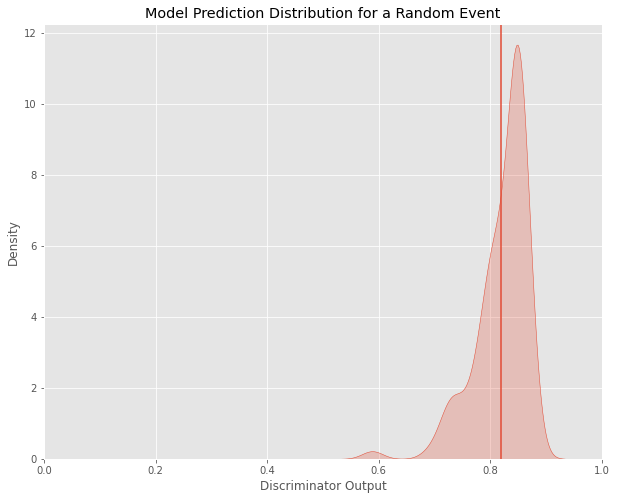

In [9]:
n_models = 100
sample, _ = generate_sample()
plot_dist(sample, model, n_models)

In [ ]:
n_samples = 1000
n_models = 10
errors = []
true_vals = []

def predict_sample(X, model, n_models):
    preds = [model(X, training=False) for _ in range(n_models)]
    mean = sum(preds) / len(preds)
    mean = float(mean[0][0])
    std = np.std(preds)
    return (mean, std)

def make_error_df(errors):
    error_df = pd.DataFrame(errors, columns=['model output', 'std'])
    true_vals_expanded = [i[0] for i in true_vals]
    error_df['event type'] = true_vals_expanded
    error_df['prediction error'] = np.abs(error_df['model output'] - error_df['event type'])
    error_df.replace(to_replace=[0, 1], value=['background', 'signal'], inplace=True)
    return error_df

def plot_output_error(error_df):
    plt.figure(figsize=(8, 8))
    plt.title('Error vs Discriminator Output')
    sns.scatterplot(x='model output', y='std', hue='event type', data=error_df, s=12, x_bins=10)

In [ ]:
for _ in tqdm(range(n_samples)):
    sample, y_true = generate_sample()
    true_vals.append(y_true)
    error = predict_sample(sample, model, n_models)
    errors.append(error)

Average Uncertainty: 0.0587
Correlation Between Predicted Error and Actual Error: 0.3006


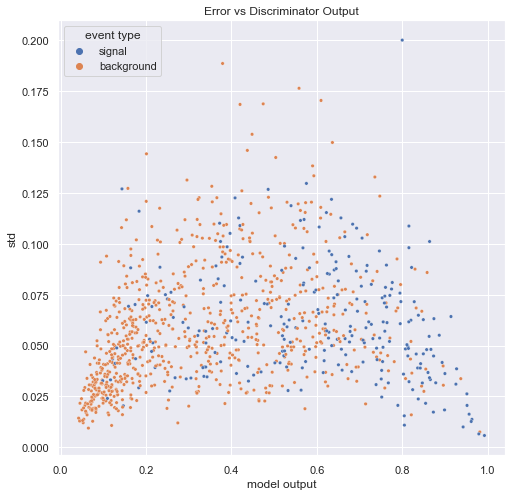

In [200]:
error_df = make_error_df(errors)
average_std = np.mean(error_df['std'])
correlation = error_df['prediction error'].corr(error_df['std'])

print(f'Average Uncertainty: {average_std:.4f}\nCorrelation Between Predicted Error and Actual Error: {correlation:.4f}')
plot_output_error(error_df)

C:\Users\Noaja\Downloads\msci_project\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


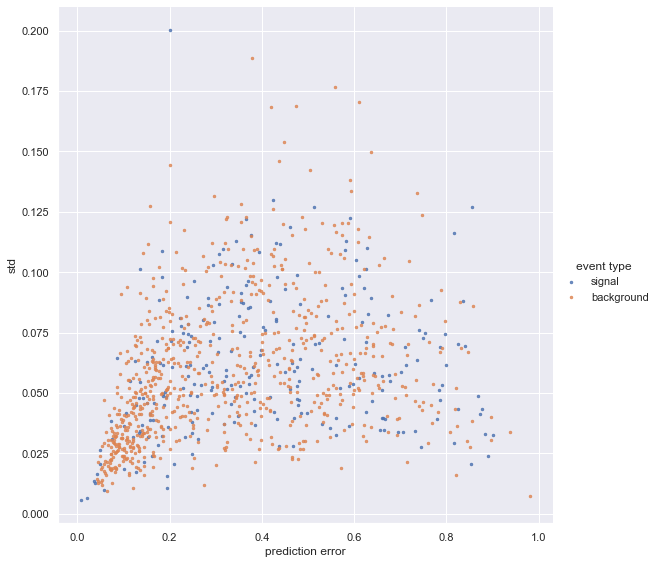

In [204]:
def plot_prediction_error(error_df):
    sns.lmplot(x='prediction error', 
               y='std', 
               hue='event type', 
               data=error_df,                
               size=8, 
               scatter_kws={"s": 6},
               #ci=None,
               fit_reg=False,
               #x_bins=100,
               )

error_df = make_error_df(errors)
plot_prediction_error(error_df)

C:\Users\Noaja\Downloads\msci_project\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


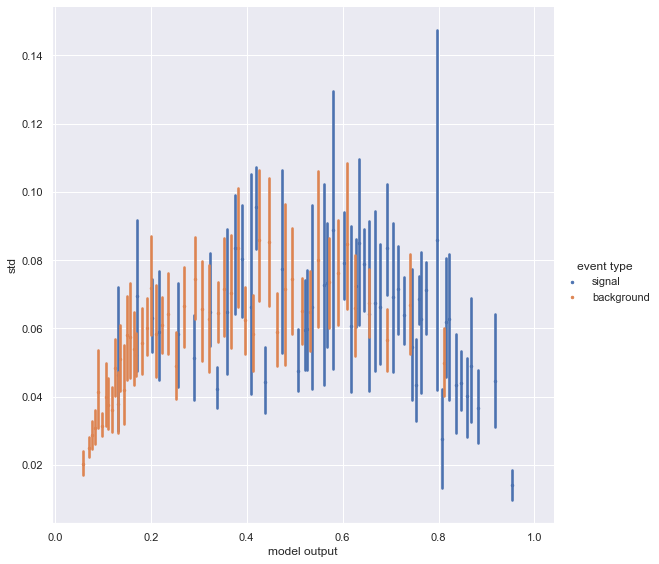

In [206]:
sns.lmplot(x='model output', 
            y='std', 
            hue='event type', 
            data=error_df,                
            size=8,
            scatter_kws={"s": 6},
            fit_reg=False,
            x_bins=50,
            )

In [ ]:
# also compare mean dropout result with the normal model output and see which is more accurate
# figure out how to implement monte carlo for recurrent dropout